In [1]:
!pip install torch torchvision matplotlib numpy scikit-learn


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from PIL import Image


In [7]:
# Define dataset paths
train_data_dir = "Dataset_new (1)/VARICOSE_VEINS_own/train/"
test_data_dir = "Dataset_new (1)/VARICOSE_VEINS_own/test/"
valid_data_dir = "Dataset_new (1)/VARICOSE_VEINS_own/valid/"

# Hyperparameters
img_height, img_width = 224, 224
batch_size = 16
num_classes = 2
learning_rate = 0.001
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transforms)
valid_dataset = datasets.ImageFolder(root=valid_data_dir, transform=test_transforms)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Class names
class_names = train_dataset.classes
print("Class Names:", class_names)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/Vinod/Documents/Dataset/train'

In [5]:
# Load pretrained ResNeXt50 model
model = models.resnext50_32x4d(pretrained=True)

# Modify the classifier
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, num_classes),
    nn.Softmax(dim=1)
)

# Move model to GPU if available
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)


C:\Users\Vinod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Vinod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to C:\Users\Vinod/.cache\torch\hub\checkpoints\resnext50_32x4d-7cdf4587.pth
100%|████

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [6]:
train_loss_values = []
valid_loss_values = []
train_acc_values = []
valid_acc_values = []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = correct_train / len(train_dataset)
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc)

    model.eval()
    valid_loss, correct_valid = 0, 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_valid += (predicted == labels).sum().item()

    valid_loss /= len(valid_loader)
    valid_acc = correct_valid / len(valid_dataset)
    valid_loss_values.append(valid_loss)
    valid_acc_values.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
          f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

# Save the trained model
torch.save(model.state_dict(), "varicose_resnext50.pth")
print("Model saved successfully!")


Epoch 1/30 - Train Loss: 0.5501, Train Acc: 0.7667 - Valid Loss: 0.7166, Valid Acc: 0.6087
Epoch 2/30 - Train Loss: 0.4334, Train Acc: 0.8667 - Valid Loss: 0.8157, Valid Acc: 0.5217
Epoch 3/30 - Train Loss: 0.4617, Train Acc: 0.8667 - Valid Loss: 0.3849, Valid Acc: 0.9348
Epoch 4/30 - Train Loss: 0.4760, Train Acc: 0.8190 - Valid Loss: 0.4403, Valid Acc: 0.8696
Epoch 5/30 - Train Loss: 0.4675, Train Acc: 0.8238 - Valid Loss: 0.6261, Valid Acc: 0.6739
Epoch 6/30 - Train Loss: 0.5029, Train Acc: 0.8571 - Valid Loss: 0.4203, Valid Acc: 0.8913
Epoch 7/30 - Train Loss: 0.4152, Train Acc: 0.8905 - Valid Loss: 0.6823, Valid Acc: 0.6304
Epoch 8/30 - Train Loss: 0.4643, Train Acc: 0.8333 - Valid Loss: 0.4791, Valid Acc: 0.8261
Epoch 9/30 - Train Loss: 0.5002, Train Acc: 0.8190 - Valid Loss: 0.4681, Valid Acc: 0.8261
Epoch 10/30 - Train Loss: 0.4569, Train Acc: 0.8762 - Valid Loss: 0.4146, Valid Acc: 0.9130
Epoch 11/30 - Train Loss: 0.4187, Train Acc: 0.9095 - Valid Loss: 0.4282, Valid Acc: 0.89

In [7]:
model.eval()
correct, total = 0, 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Generate classification report
print(classification_report(all_labels, all_preds, target_names=class_names))


Test Accuracy: 93.18%
              precision    recall  f1-score   support

      normal       0.95      0.91      0.93        22
    varicose       0.91      0.95      0.93        22

    accuracy                           0.93        44
   macro avg       0.93      0.93      0.93        44
weighted avg       0.93      0.93      0.93        44



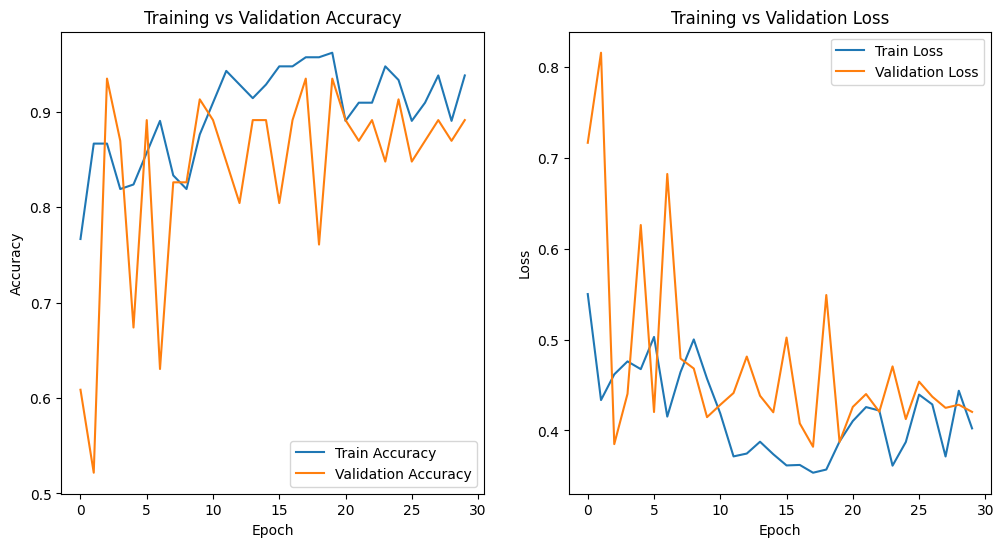

In [8]:
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(valid_acc_values, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_loss_values, label='Train Loss')
plt.plot(valid_loss_values, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


The image is classified as: varicose


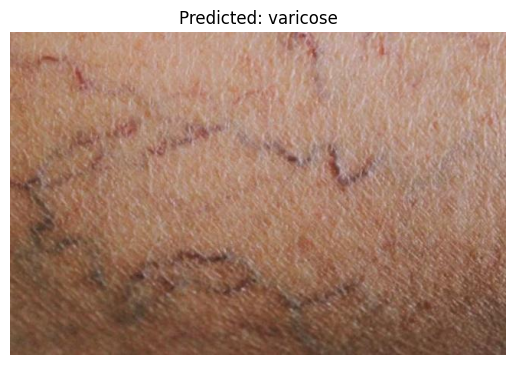

In [12]:
# Load a test image for prediction
test_image_path = "C:/Users/Vinod/Downloads/Varicose Vein Detection/Varicose Vein Detection/Dataset_new (1)/VARICOSE_VEINS_own/test/varicose/58_jpeg.rf.8522e59123b36d6d23b859456e609e22.jpg"

# Load and preprocess image
img = Image.open(test_image_path)
img = test_transforms(img)
img = img.unsqueeze(0).to(device)  # Add batch dimension

# Make predictions
model.eval()
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]

print(f"The image is classified as: {predicted_class}")

# Display the image
plt.imshow(Image.open(test_image_path))
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


The image is classified as: normal


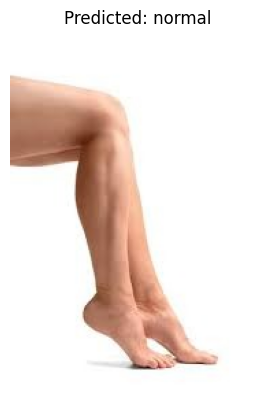

In [13]:
# Load a test image for prediction
test_image_path = "C:/Users/Vinod/Downloads/Varicose Vein Detection/Varicose Vein Detection/Dataset_new (1)/VARICOSE_VEINS_own/valid/normal/nor_image_197_jpeg.978jsanija.jpeg"

# Load and preprocess image
img = Image.open(test_image_path)
img = test_transforms(img)
img = img.unsqueeze(0).to(device)  # Add batch dimension

# Make predictions
model.eval()
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]

print(f"The image is classified as: {predicted_class}")

# Display the image
plt.imshow(Image.open(test_image_path))
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


The image is classified as: varicose


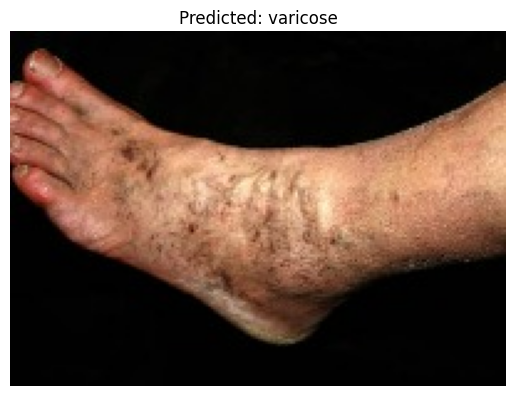

In [14]:
# Load a test image for prediction
test_image_path = "image.png"

# Load and preprocess image
img = Image.open(test_image_path)
img = test_transforms(img)
img = img.unsqueeze(0).to(device)  # Add batch dimension

# Make predictions
model.eval()
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]

print(f"The image is classified as: {predicted_class}")

# Display the image
plt.imshow(Image.open(test_image_path))
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


The image is classified as: normal


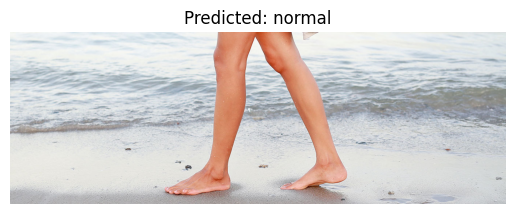

In [15]:
# Load a test image for prediction
test_image_path = "image.png"

# Load and preprocess image
img = Image.open(test_image_path)
img = test_transforms(img)
img = img.unsqueeze(0).to(device)  # Add batch dimension

# Make predictions
model.eval()
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]

print(f"The image is classified as: {predicted_class}")

# Display the image
plt.imshow(Image.open(test_image_path))
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


In [ ]:

# Additional Classification: Determine Stage of Varicose Veins

if predicted_class == 1:  # Assuming class 1 is Varicose
    # Load a pre-trained model for staging (if available) or define a simple classifier
    staging_model = models.resnext50_32x4d(pretrained=True)
    staging_model.fc = nn.Sequential(
        nn.Linear(staging_model.fc.in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 3),  # Assuming 3 stages of varicose veins
        nn.Softmax(dim=1)
    )
    staging_model.to(device)
    staging_model.eval()

    with torch.no_grad():
        stage_output = staging_model(img)
        _, stage_pred = torch.max(stage_output, 1)

    stage_mapping = {0: "Stage 1", 1: "Stage 2", 2: "Stage 3"}
    varicose_stage = stage_mapping[stage_pred.item()]
    print(f"Varicose Veins detected - {varicose_stage}")
else:
    print("Normal Image detected.")
